In [1]:
# Importar librerias
import pandas as pd
import netCDF4 as nc
import numpy as np
import cv2
import os
import errno
import geopandas as gpd
import seaborn as sns
import shapely
from shapely.geometry import shape, Polygon, Point, MultiPoint, box, LineString

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import cartopy
from cartopy import config
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from cmcrameri import cm
from cartopy.io.shapereader import Reader as sf
from cartopy.feature import ShapelyFeature as cfeature
import cartopy.io.img_tiles as cimgt

In [34]:
# FUNCIONES UTILES
def clasificar_municipio(lat_mun, lon_mun, lat_ciclon, lon_ciclon, m_perpendicular, direccion_movimiento):
    # Calcular si un municipio está 'delante' o 'detrás' de la línea perpendicular
    y_esperado = m_perpendicular * (lon_mun - lon_ciclon) + lat_ciclon
    
    if direccion_movimiento <= 180:
        return 'Acercando' if lat_mun > y_esperado else 'Alejando'
    else:
        return 'Acercando' if lat_mun < y_esperado else 'Alejando'

def configurar_mapa(ax, lon_extent=[-98, -86], lat_extent=[ 14, 22]):
    """
    Configura los elementos comunes del mapa para un subplot ax.
    """
    # Añadir márgenes al mapa
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=2)
    ax.add_feature(cartopy.feature.BORDERS, linewidth=2)
    ax.add_feature(cartopy.feature.LAND.with_scale('50m'), facecolor='lightgrey', alpha=0.8, zorder=0)

    # Configurar los ticks y márgenes con el grosor deseado
    ax.spines['geo'].set_linewidth(3)  # Grosor del contorno exterior del mapa
    ax.tick_params(axis='both', width=3, which='both', labelsize=16)  # Grosor de los ticks

    ax.set_extent(lon_extent + lat_extent, ccrs.PlateCarree())

    ax.set_xticks(np.arange(lon_extent[0], lon_extent[1] + 1, 1), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_extent[0], lat_extent[1] + 1, 1), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # Añadir líneas de coordenadas cada 3 grados en el eje inferior
    ax.gridlines(draw_labels=False, linewidth=1, color='w', alpha=0.6, linestyle='--', zorder=3,
                 xlocs=range(lon_extent[0], lon_extent[1] + 1, 1), ylocs=range(lat_extent[0], lat_extent[1] + 1, 1))

In [37]:
# TABLA DE ACERCAMIENTO
TA = pd.DataFrame()
TA[0] = [1,1,1,1,1,1]
TA[1] = [2,2,2,2,2,2]
TA[2] = [2,2,2,2,3,3]
TA[3] = [2,2,3,3,3,3]
TA[4] = [2,3,3,3,4,4]
TA[5] = [3,3,4,4,4,4]
TA[6] = [3,4,4,4,4,4]
TA[7] = [4,4,4,4,5,5]
TA[8] = [5,5,5,5,5,5]

def class_h(val):
    if val > 72:
        i = 0
    elif (val <72)&(val>=60):
        i = 1
    elif (val <60)&(val>=48):
        i = 2
    elif (val <48)&(val>=36):
        i = 3
    elif (val <36)&(val>=24):
        i = 4
    elif (val <24)&(val>=18):
        i = 5
    elif (val <18)&(val>=12):
        i = 6
    elif (val <12)&(val>=6):
        i = 7
    elif (val <6):
        i = 8
    return i 

In [38]:
# TABLA DE ALEJAMIENTO
TL = pd.DataFrame()
TL[0] = [5,5,5,5,5,5]
TL[1] = [4,4,5,5,5,5]
TL[2] = [4,4,4,4,5,5]
TL[3] = [3,4,4,4,4,5]
TL[4] = [3,3,3,4,4,4]
TL[5] = [3,3,3,3,4,4]
TL[6] = [2,3,3,3,3,4]
TL[7] = [2,2,2,3,3,3]
TL[8] = [2,2,2,2,2,2]
TL[9] = [1,1,1,1,1,1]

def class_d(val):
    if val < 100:
        i = 0
    elif (val <150)&(val>=100):
        i = 1
    elif (val <200)&(val>=150):
        i = 2
    elif (val <250)&(val>=200):
        i = 3
    elif (val <300)&(val>=250):
        i = 4
    elif (val <350)&(val>=300):
        i = 5
    elif (val <400)&(val>=350):
        i = 6
    elif (val <500)&(val>=400):
        i = 7
    elif (val <750)&(val>=500):
        i = 8
    elif (val >=750):
        i = 9
    return i 

# Cargar los datos de trayectoria e información del CT
### Descripcion de la información 

**'NAME'**: Name provided by the agency.

**'ISO_TIME'**: ISO Time provided in Universal Time Coordinates (UTC). Format is YYYY-MM-DD HH mm ss

**'USA_LAT'**: deg north

**'USA_LON'**: deg_east

**'USA_WIND'**: Maximum sustained wind speed in knots: 0 - 300 kts.

**'USA_PRES'**: Minimum sea level pressure, 850 - 1050 mb.

**'USA_SSHS'**: Saffir-Simpson Hurricane Scale information based on the wind speed provided by the US agency wind speed (US agencies provide 1-minute wind speeds): 

        * -5 = Unknown [XX]
        * -4 = Post-tropical [EX, ET, PT]
        * -3 = Miscellaneous disturbances [WV, LO, DB, DS, IN, MD]
        * -2 = Subtropical [SS, SD]
        
        Tropical systems classified based on wind speeds:
        * -1 = Tropical depression (W<34)
        * 0 = Tropical storm [34<W<64]
        * 1 = Category 1 [64<=W<83] 
        * 2 = Category 2 [83<=W<96] 
        * 3 = Category 3 [96<=W<113]
        * 4 = Category 4 [113<=W<137] 
        * 5 = Category 5 [W >= 137]

**'USA_R34_NE'**: 34 kt wind radii maximum extent in northeastern quadrant in nautical milles

**'USA_R34_SE'**: 34 kt wind radii maximum extent in southeastern quadrant in nautical milles

**'USA_R34_SW'**: 34 kt wind radii maximum extent in southwestern quadrant in nautical milles

**'USA_R34_NW'**: 34 kt wind radii maximum extent in northwestern quadrant in nautical milles

**'STORM_SPD'**: Translation speed of the system as calculated from the positions in LAT and LON in knots

**'STORM_DR'**: Translation direction of the system as calculated from the positions in LAT and LON. Direction is moving toward the vector pointing in degrees east of north [range = 0-360 deg]

In [17]:
ct_ibtracs = gpd.read_file('cristobal_ibtracks.shp')
columnas = [5,6,19,20,23,24,25,26,27,28,29,161,162]
ct_ibtracs_info = ct_ibtracs.iloc[:,columnas]

In [18]:
# limpieza para aquellas posiciones que requieren alertamientos (-1 a 5)

df = ct_ibtracs_info[ct_ibtracs_info.USA_SSHS.ge(-1)].copy()

Para empezar es necesario calcular la peligrosidad asociada al SIAT-CT para cada CT. Para ello necesitamos los valores de 

**Escala de Intensidad** : ['ESC_INT'] Categoría del Huracán en la escala Saffir-Simpson o I = 0 si se trata de una Depresión o una Tormenta Tropical.

**Escala de Circulación** : ['ESC_CIR'] la Escala de Circulación y se obtiene de: C = 0.0377 R; donde R es el radio promedio (en millas náuticas) de los cuatro cuadrantes de la isotaca de 34 nudos (63 km/h)

In [19]:
## Escala de intensidad 
df['ESC_INT'] = df['USA_SSHS'].apply(lambda x: x if x >= 1 else 0)

In [20]:
## Escala de circulación
df['R'] = df[['USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW']].mean(axis=1)
df['R'] = df['R'].ffill()
df['ESC_CIR'] = 0.0377 * df['R']
# Ajustar los valores de ESC_CIR para que ningún valor exceda de 5
df['ESC_CIR'] = np.where(df['ESC_CIR'] > 5, 5, df['ESC_CIR'])

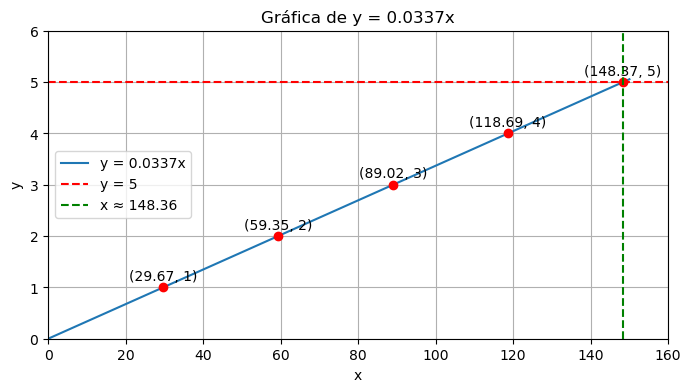

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Valores de x desde 0 hasta 150
x = np.linspace(0, 150, 400)
y = 0.0337 * x

plt.figure(figsize=(8, 4))  # tamaño de la figura
plt.plot(x, y, label='y = 0.0337x')

# Marcas para los puntos donde y es 1, 2, 3, 4, y 5
ys = [1, 2, 3, 4, 5]
xs = [1/0.0337, 2/0.0337, 3/0.0337, 4/0.0337, 5/0.0337]
for i, val in enumerate(ys):
    plt.plot(xs[i], val, 'ro')  # marca los puntos con un círculo rojo
    plt.annotate(f'({xs[i]:.2f}, {val})', (xs[i], val), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('Gráfica de y = 0.0337x')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.axhline(5, color='r', linestyle='--', label='y = 5')
plt.axvline(148.36, color='g', linestyle='--', label='x ≈ 148.36')
plt.legend()
plt.xlim(0, 160)  # ajustar los límites de x
plt.ylim(0, 6)   # ajustar los límites de y
plt.show()


#### Calculo de la peligrosidad del CT con la información antes calculada:
El SIAT CT considera la extensión del ciclón tropical en superficie. Para ello se emplea una Escala
Promedio de las escalas Saffir-Simpson y de Circulación.
La Escala Promedio (e) se obtiene con la siguiente ecuación:
$$e = 0.5 (I+C)$$


In [22]:
# Calcular la Escala Promedio (e) usando la fórmula proporcionada
df['ESC_PEL'] = 0.5 * (df['ESC_INT'] + df['ESC_CIR'])
df['ESC_PEL'] = df['ESC_PEL'].round(2)
df['ESC_PEL'] = df['ESC_PEL'].fillna(0)

#### Cálculo del alertamiento por municipio afectado
Para esto es importante considerar la posición del ciclon tropical y apartir de a dirección de movimiento en grados dados por la columna 'STORM_DR' en un rango de 0 a 360, hay que determinar aquellos municipios de los que se aleja el ciclón y de cuales se acerca. Luego una vez separados los municipios en estos dos grupos hay que determinar dos cosas. Para los que se aleja, la distancia del CT al centro en movimiento. Para los que se acerca en cuanto tiempo el ciclón estará cercano. Y esto en función de la velocidad de traslación o desplazamiento del ciclón tropical el cual esta dada por la columna 'STORM_SPD' donde se expresa en nudos dicha velocidad. Toma en cuenta que la distancia de alejamiento es en KM y el tiempo de acercamiento en Horas.

In [23]:
fname = 'C:/Users/adolf/Downloads/municipios/mun22gw.shp'

shapefile = gpd.read_file(fname,  encoding='utf-8')

In [24]:
gdf_municipios = shapefile.loc[(shapefile['CVE_ENT'] == '04')|(shapefile['CVE_ENT'] == '07')|(shapefile['CVE_ENT'] == '20')|
              (shapefile['CVE_ENT'] == '23')|(shapefile['CVE_ENT'] == '27')|(shapefile['CVE_ENT'] == '30')|
              (shapefile['CVE_ENT'] == '31')].reset_index(drop =True)

Primero, calculamos el centroide de cada polígono (municipio). Asumiremos que gdf_municipios es tu GeoDataFrame que contiene la geometría de los municipios.

In [25]:
gdf_municipios['centroide'] = gdf_municipios.geometry.centroid
gdf_municipios['lat_centroide'] = gdf_municipios.centroide.y
gdf_municipios['lon_centroide'] = gdf_municipios.centroide.x

C:\Users\adolf\AppData\Local\Temp\ipykernel_32040\2251888287.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_municipios['centroide'] = gdf_municipios.geometry.centroid


In [27]:
df_ciclon =  df.copy()

# A partir de aqui hayq ue determinar el día para los alertaminetos en la variable indice_dia

In [28]:
indice_dia =  24
# Dirección del movimiento del ciclón en grados

direccion_movimiento = df_ciclon['STORM_DR'].iloc[indice_dia] - 90
lat_ciclon, lon_ciclon = df_ciclon['USA_LAT'].iloc[indice_dia], df_ciclon['USA_LON'].iloc[indice_dia]
#20.2069, -91.9754#
# Convertir dirección a radianes
theta_radianes = np.radians(direccion_movimiento)

# Calcular pendiente de la dirección de movimiento y de la perpendicular
m_movimiento = np.tan(theta_radianes)
m_perpendicular = -1/m_movimiento

In [29]:
# Aplicar la función clasificar_municipio a cada fila del GeoDataFrame
nombre_columna = 'clasificacion_'+df_ciclon.iloc[indice_dia].ISO_TIME[:10]
gdf_municipios[nombre_columna] = gdf_municipios.apply(
    lambda x: clasificar_municipio(
        x['lat_centroide'], x['lon_centroide'], 
        lat_ciclon, lon_ciclon, 
        m_perpendicular, direccion_movimiento
    ), axis=1
)

In [30]:
gdf_acercando = gdf_municipios[gdf_municipios[nombre_columna] == 'Acercando'].copy()
gdf_alejando = gdf_municipios[gdf_municipios[nombre_columna] == 'Alejando'].copy()

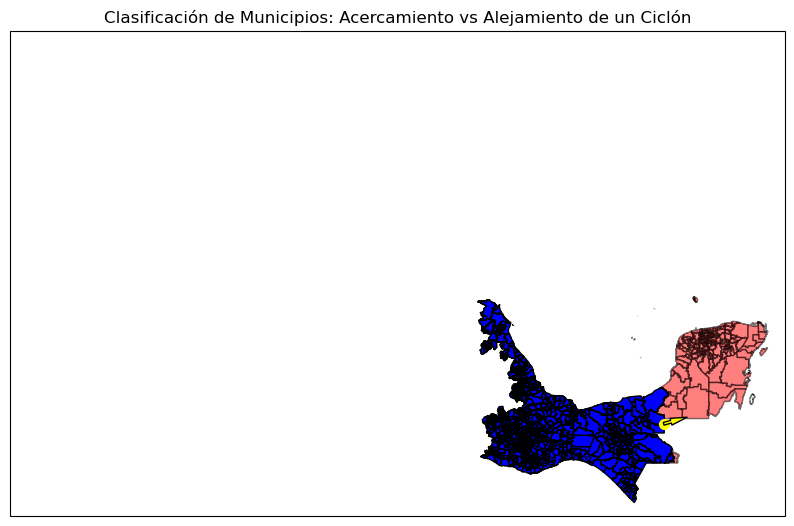

In [33]:
import numpy as np

# Datos del ciclón (ejemplo)
lat_ciclon = lat_ciclon  # Latitud del centro del ciclón
lon_ciclon = lon_ciclon  # Longitud del centro del ciclón
direccion_movimiento = direccion_movimiento  # Dirección de movimiento en grados

# Calcular el desplazamiento de la flecha para la dirección del ciclón
longitud_flecha = 1  # Longitud de la flecha en grados, ajusta según la escala de tu mapa
dx = longitud_flecha * np.cos(np.radians(direccion_movimiento))
dy = longitud_flecha * np.sin(np.radians(direccion_movimiento))

# Ahora, incluyendo el centro del ciclón y la dirección en el map


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-118, -86, 14, 33], crs=ccrs.PlateCarree())  # Ajusta estos límites para enfocar tu área de interés en México

# # Agrega los features del mapa
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.OCEAN)
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# Grafica los municipios clasificados
gdf_acercando.plot(ax=ax, color='red', alpha = 0.5, edgecolor='k', label='Acercando', transform=ccrs.PlateCarree())
gdf_alejando.plot(ax=ax, color='blue', edgecolor='k', label='Alejando', transform=ccrs.PlateCarree())

# Marcar el centro del ciclón
ax.plot(lon_ciclon, lat_ciclon, marker='o', color='yellow', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')

# Dibujar la dirección del ciclón
ax.annotate('', xy=(lon_ciclon + dx, lat_ciclon + dy), xytext=(lon_ciclon, lat_ciclon),
            arrowprops=dict(facecolor='yellow', shrink=0, width=2, headwidth=5),
            transform=ccrs.Geodetic())

# Añade una leyenda y un título
plt.title('Clasificación de Municipios: Acercamiento vs Alejamiento de un Ciclón')

plt.show()
